# 05 - Defending against Adversarial Examples

We saw how to attack models, but we also need to take into account defending against them.
In particular, we will learn here how to create a simplified version of **adversarial training**.

As seen in class, this technique is defined as:
$$
\min_{\boldsymbol{\theta}} \sum_{(\boldsymbol{x},y) \in D} \max_{\boldsymbol{\delta}} L(\boldsymbol{x}+\boldsymbol{\delta}, y;\boldsymbol{\theta})
$$

which accounts for computing the best parameters $\boldsymbol{\theta}$ that minimizes the error in the presence of worst-case adversarial noise $\boldsymbol{\delta}$.

This is nice in theory, but implementing this is hard and resource demanding.

In [1]:
try:
    import secmlt

except ImportError:
    print("Installing the dependancies")
    %pip install git+https://github.com/pralab/secml-torch

In [2]:
import torch
import numpy as np
import random

seed = 999
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)

from secmlt.models.pytorch.base_pytorch_nn import BasePytorchClassifier
from secmlt.models.pytorch.base_pytorch_trainer import BasePyTorchTrainer
from secmlt.metrics.classification import Accuracy
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_blobs
import numpy as np
import matplotlib.pyplot as plt
import torch

def plot_decision_regions(model, X, y, title="Decision Regions"):
    """
    Plot decision regions for a PyTorch model.
    
    Args:
        model: PyTorch model (must be in eval mode)
        X: Input features as tensor
        y: Labels as tensor
        title: Plot title
    """
    # Convert tensors to numpy for plotting
    X_np = X.detach().numpy()
    y_np = y.detach().numpy()
    
    # Create a mesh grid
    x_min, x_max = X_np[:, 0].min() - 0.5, X_np[:, 0].max() + 0.5
    y_min, y_max = X_np[:, 1].min() - 0.5, X_np[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                        np.linspace(y_min, y_max, 200))
    
    # Get predictions for each point in the mesh
    X_mesh = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])
    with torch.no_grad():
        model.eval()
        Z = model(X_mesh)
        Z = torch.argmax(Z, dim=1)
    Z = Z.numpy().reshape(xx.shape)
    
    # Plot decision regions
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, alpha=0.4, cmap='viridis')
    # Plot data points
    scatter = plt.scatter(X_np[:, 0], X_np[:, 1], c=y_np, 
                         cmap='viridis')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title(title)
    plt.show()

centers = [(0, 1), (0, 0), (1, 1)]
cluster_std = 0.25
X_train, y_train = make_blobs(n_samples=500, 
                  centers=centers,
                  n_features=2,
                  cluster_std=cluster_std,
                  random_state=seed)
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)

X_test, y_test = make_blobs(n_samples=100, 
                  centers=centers,
                  n_features=2,
                  cluster_std=cluster_std,
                  random_state=seed)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

tr_dataloader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=False)
ts_dataloader = DataLoader(TensorDataset(X_test, y_test), batch_size=5, shuffle=False)

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(2, 32)  
        self.fc2 = torch.nn.Linear(32, 16)
        self.fc3 = torch.nn.Linear(16, 3)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

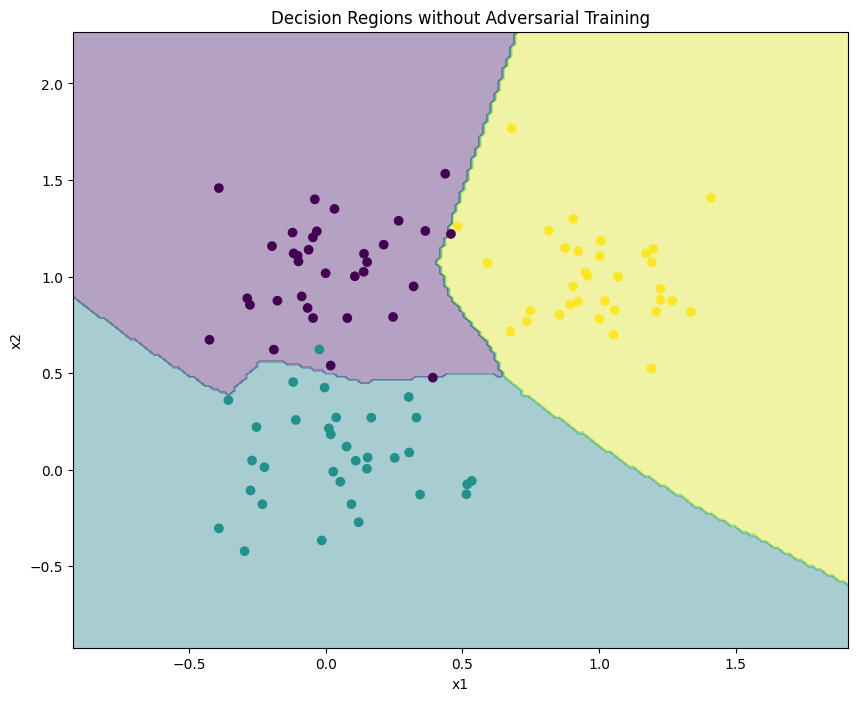

In [3]:
epochs = 1000
lr = 1e-3

net2 = Net()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net2.parameters(), lr=lr)

trainer = BasePyTorchTrainer(optimizer=optimizer, loss=criterion, epochs=epochs)
secmlt_model = BasePytorchClassifier(net2, trainer=trainer)
secmlt_model.train(tr_dataloader)

plot_decision_regions(secmlt_model.model, X_test, y_test, title="Decision Regions without Adversarial Training")

Given this network, we need to tweak the training loop that we saw at the beginning of the course.
Since we have a deep neural network, we **can not** compute adversarial training in closed form.

Hence, the only way is *approximating* the technique by iteratively create adversarial examples while optimizing.
This can be done in multiple ways:

* at each iteration, we create adversarial examples and include them in training (very time consuming)
* train the model for some epochs, compute adversarial attacks, include them in the training, repeat
* fine-tune the trained model with one attack with larger epsilon (less granular, but fast)

Here we are going to use a very easy approach, through Fast Gradient Sign Method (FGSM), which is a single-step attack with a large L-infinity norm.

In [4]:
model= Net()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss()

epsilon = 0.3

for epoch in range(epochs):
    running_loss = 0.0

    for inputs, labels in tr_dataloader:
        # Compute adversarial samples with 1-iteration attack
        model.eval()
        x = inputs.clone().detach().requires_grad_(True)
        outputs = model(x)
        loss = criterion(outputs, labels)
        loss.backward()
        gradient = x.grad.data
        inputs_adv = x.data + epsilon * torch.sign(gradient)

        # Compute loss and backpropagate as usual
        model.train()
        optimizer.zero_grad()
        outputs = model(inputs_adv)
        loss = criterion(outputs, labels)
        loss.backward()                 
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    
    epoch_loss = running_loss / len(tr_dataloader.dataset)
    
    if (epoch+1) % 100 == 0:
        print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")

at_model = BasePytorchClassifier(model)

Epoch 100, Loss: 0.6547
Epoch 200, Loss: 0.6502
Epoch 300, Loss: 0.6425
Epoch 400, Loss: 0.6336
Epoch 500, Loss: 0.6302
Epoch 600, Loss: 0.6117
Epoch 700, Loss: 0.5802
Epoch 800, Loss: 0.5500
Epoch 900, Loss: 0.5086
Epoch 1000, Loss: 0.4932


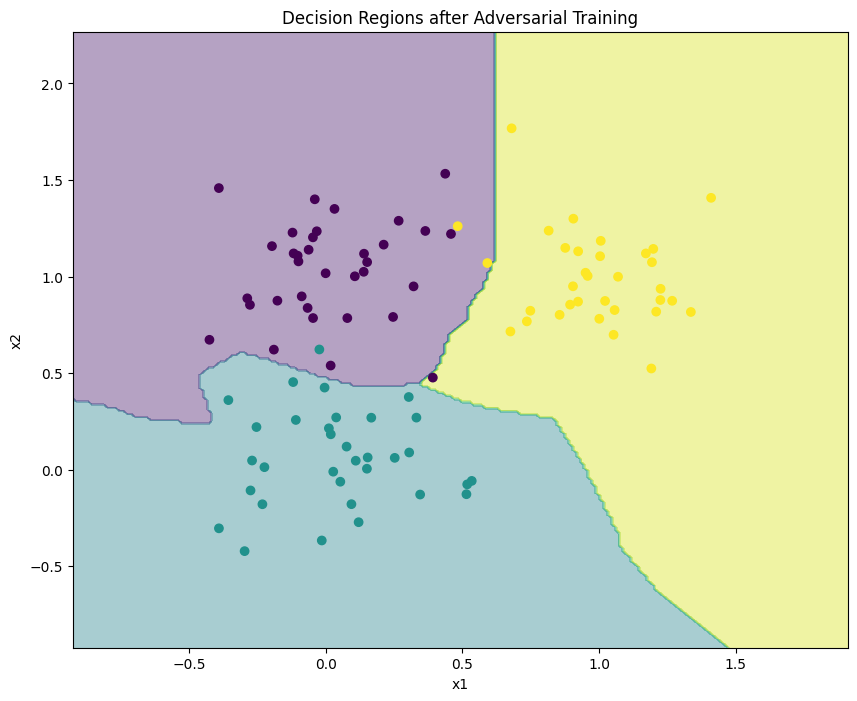

In [5]:
plot_decision_regions(model, X_test, y_test, title="Decision Regions after Adversarial Training")

# Exercise 1
* Perform a security evaluation of both model under the same attack condition (for simplicity, use a PGD attack with varying epsilon)
* Plot the security evaluation curves in the same plot, and try to understand what the comparison is telling regarding the robustness of these models.

In [6]:
from secmlt.adv.evasion.pgd import PGD
from secmlt.adv.backends import Backends
from secmlt.adv.evasion.perturbation_models import LpPerturbationModels

def security_evaluation_pgd_linf(model, testloader, epsilons, iterations=100, stepsize=0.01):
    sec_eval_data = []

    for e in epsilons:
        attack = PGD(
            perturbation_model=LpPerturbationModels.LINF,
            num_steps=iterations,
            step_size=stepsize,
            y_target=None,
            epsilon=e,
            lb=-2,ub=2,
            backend = Backends.NATIVE)
        
        adv_dataloader = attack(model, testloader)
        robust_accuracy = Accuracy()(model, adv_dataloader)
        sec_eval_data.append(robust_accuracy)
        
    return sec_eval_data

In [7]:
epsilons = torch.linspace(0, 1.5, steps=10)
iterations = 500

#First model: trained normally
security_eval_no_at = security_evaluation_pgd_linf(secmlt_model, ts_dataloader, epsilons=epsilons, iterations=iterations, stepsize=0.1)

#Second model: trained with adversarial training
security_eval_at = security_evaluation_pgd_linf(at_model, ts_dataloader, epsilons=epsilons, iterations=iterations, stepsize=0.1)

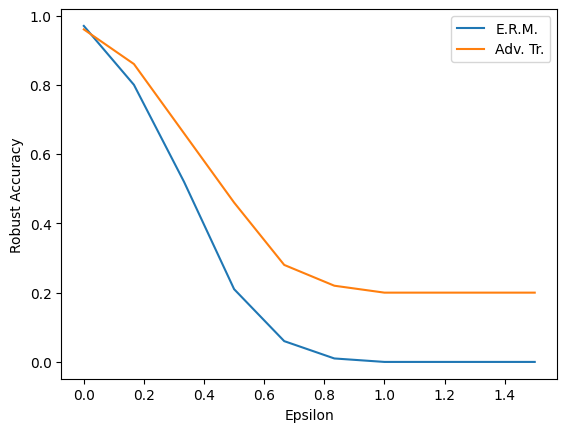

In [8]:
import matplotlib.pyplot as plt

plt.plot(epsilons.numpy(), security_eval_no_at, label='E.R.M.')
plt.plot(epsilons.numpy(), security_eval_at, label='Adv. Tr.')
plt.xlabel('Epsilon')
plt.ylabel('Robust Accuracy')
plt.legend()
plt.show()

ERM drops quickly to 0, as is not robust.<br>
AdvTr declines more slowly and retains accuracy at high $\epsilon$.<br>
There's a large gap between curves, as there's a robustness gain thanks to adversarial training.

# Exercise 2

* Try to change the attack used in adversarial training, for instance using PGD or by increasing the epsilon. What happens if epsilon is too large?
* What happens if the model does not have too many parameters? Can you successfully train it with adversarial training?
* Change the norm of the security evaluations, and comment them.

## Ex 2.1

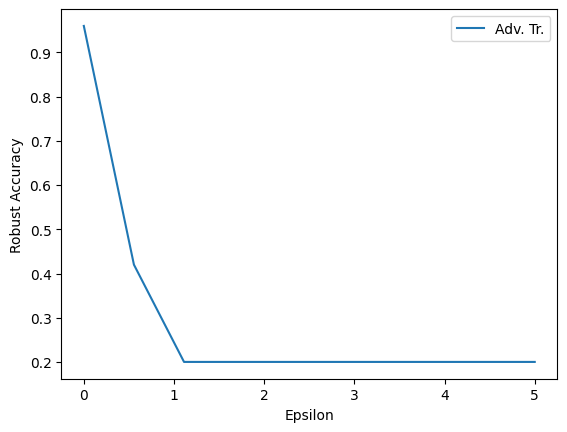

In [9]:
def security_evaluation_pgd_linf(model, testloader, epsilons, iterations=100, stepsize=0.01):
    sec_eval_data = []

    for e in epsilons:
        attack = PGD(
            perturbation_model=LpPerturbationModels.LINF,
            num_steps=iterations,
            step_size=stepsize,
            y_target=None,
            epsilon=e,
            lb=-2,ub=2,
            backend = Backends.NATIVE)
        
        adv_dataloader = attack(model, testloader)
        robust_accuracy = Accuracy()(model, adv_dataloader)
        sec_eval_data.append(robust_accuracy)
        
    return sec_eval_data

epsilons = torch.linspace(0, 5, steps=10)
security_eval = security_evaluation_pgd_linf(at_model, ts_dataloader, epsilons=epsilons, iterations=iterations, stepsize=0.1)

plt.plot(epsilons.numpy(), security_eval, label='Adv. Tr.')
plt.xlabel('Epsilon')
plt.ylabel('Robust Accuracy')
plt.legend()
plt.show()

Witth $\epsilon$ very large, the adversarial attack becomes overwhelmingly strong and the classifier can no longer resist any perturbation: robust accuracy falls to zero and stays at zero.<br>
Increasing $\epsilon$ further has no additional effect.

## Ex 2.2

Epoch 100, Loss: 0.6731
Epoch 200, Loss: 0.6655
Epoch 300, Loss: 0.6616
Epoch 400, Loss: 0.6556
Epoch 500, Loss: 0.6532
Epoch 600, Loss: 0.6486
Epoch 700, Loss: 0.6464
Epoch 800, Loss: 0.6417
Epoch 900, Loss: 0.6391
Epoch 1000, Loss: 0.6329


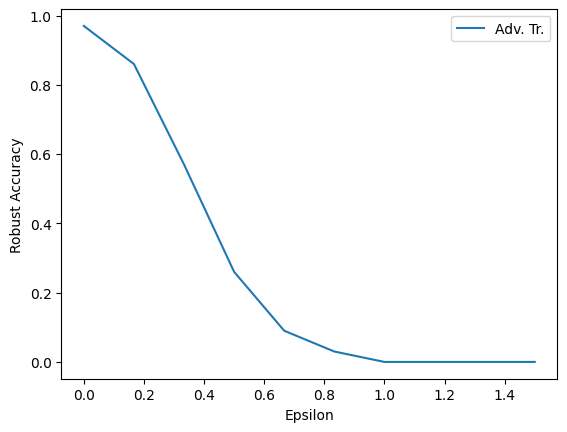

In [10]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(2, 8)  
        self.fc2 = torch.nn.Linear(8, 8)
        self.fc3 = torch.nn.Linear(8, 3)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

model= Net()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss()
epsilon = 0.3

for epoch in range(epochs):
    running_loss = 0.0

    for inputs, labels in tr_dataloader:
        # Compute adversarial samples with 1-iteration attack
        model.eval()
        x = inputs.clone().detach().requires_grad_(True)
        outputs = model(x)
        loss = criterion(outputs, labels)
        loss.backward()
        gradient = x.grad.data
        inputs_adv = x.data + epsilon * torch.sign(gradient)

        # Compute loss and backpropagate as usual
        model.train()
        optimizer.zero_grad()
        outputs = model(inputs_adv)
        loss = criterion(outputs, labels)
        loss.backward()                 
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    
    epoch_loss = running_loss / len(tr_dataloader.dataset)
    
    if (epoch+1) % 100 == 0:
        print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")

at_model = BasePytorchClassifier(model)
epsilons = torch.linspace(0, 1.5, steps=10)
iterations = 500

security_eval_at = security_evaluation_pgd_linf(at_model, ts_dataloader, epsilons=epsilons, iterations=iterations, stepsize=0.1)

plt.plot(epsilons.numpy(), security_eval_at, label='Adv. Tr.')
plt.xlabel('Epsilon')
plt.ylabel('Robust Accuracy')
plt.legend()
plt.show()

I can train it, but performance will be lower than ERM, especially if the model is very small.

## Ex 2.3

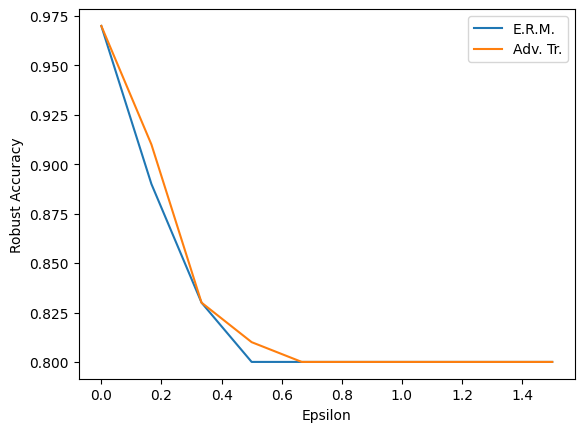

In [13]:
def security_evaluation_pgd_l1(model, testloader, epsilons, iterations=100, stepsize=0.01):
    sec_eval_data = []
    
    for e in epsilons:
        attack = PGD(
            perturbation_model=LpPerturbationModels.L1,
            num_steps=iterations,
            step_size=stepsize,
            y_target=None,
            epsilon=e,
            lb=-2,ub=2,
            backend = Backends.NATIVE)
        adv_dataloader = attack(model, testloader)
        robust_accuracy = Accuracy()(model, adv_dataloader)
        sec_eval_data.append(robust_accuracy)

    return sec_eval_data

epsilons = torch.linspace(0, 1.5, steps=10)
iterations = 500
security_eval_no_at = security_evaluation_pgd_l1(secmlt_model, ts_dataloader, epsilons=epsilons, iterations=iterations, stepsize=0.1)
security_eval_at = security_evaluation_pgd_l1(at_model, ts_dataloader, epsilons=epsilons, iterations=iterations, stepsize=0.1)

plt.plot(epsilons.numpy(), security_eval_no_at, label='E.R.M.')
plt.plot(epsilons.numpy(), security_eval_at, label='Adv. Tr.')
plt.xlabel('Epsilon')
plt.ylabel('Robust Accuracy')
plt.legend()
plt.show()

L1 PGD produces larger sparse perturbations, so even small $\epsilon$ are impactful: accuracy drops quickly between $\epsilon=0$ and $\epsilon=0.3,0.4$.<br>
Adversarial training improves robustness for the norm used during training, but with L1 it's harder: it's steeper than L_inf and slightly less than L2.<br>
Overall, the model is not very robust, as L1 may require stronger regularization/larger models.

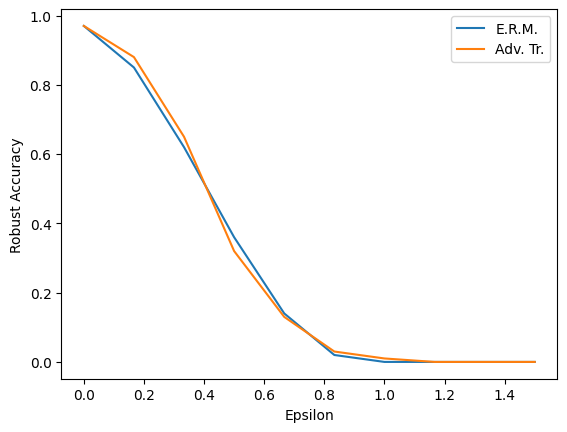

In [14]:
def security_evaluation_pgd_l2(model, testloader, epsilons, iterations=100, stepsize=0.01):
    sec_eval_data = []

    for e in epsilons:
        attack = PGD(
            perturbation_model=LpPerturbationModels.L2,
            num_steps=iterations,
            step_size=stepsize,
            y_target=None,
            epsilon=e,
            lb=-2,ub=2,
            backend = Backends.NATIVE)
        adv_dataloader = attack(model, testloader)
        robust_accuracy = Accuracy()(model, adv_dataloader)
        sec_eval_data.append(robust_accuracy)
        
    return sec_eval_data

epsilons = torch.linspace(0, 1.5, steps=10)
iterations = 500
security_eval_no_at = security_evaluation_pgd_l2(secmlt_model, ts_dataloader, epsilons=epsilons,iterations=iterations, stepsize=0.1)
security_eval_at = security_evaluation_pgd_l2(at_model, ts_dataloader, epsilons=epsilons,iterations=iterations, stepsize=0.1)

plt.plot(epsilons.numpy(), security_eval_no_at, label='E.R.M.')
plt.plot(epsilons.numpy(), security_eval_at, label='Adv. Tr.')
plt.xlabel('Epsilon')
plt.ylabel('Robust Accuracy')
plt.legend()
plt.show()

The accuracy degrades more gradualy compared to the L1 case.<br>
This is because L_inf distributes the allowed perturbation uniformly across all input features, making it less aggressive for the same $\epsilon$.<br>
Adversarial training is particularly effective against L_inf attacks, leading to a visibly larger robustness gap between ERM and AT than what was observed for L1.<br>
The AT model maintains higher accuracy for a wider range of $\epsilon$ values, while the ERM model deteriorates rapidly even for small perturbations.<br>
Moreover, accuracy saturation occurs at larger $\epsilon$ levels, reflecting the lower destructive power of L_inf perturbations in this setting.